<a href="https://colab.research.google.com/github/matchamilkers/Landscape-Image-Classification/blob/main/CS478_Final_Project_ResNet50_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ResNet50 IMPLEMENTATION:**
**Elisa Byfield**

dataset used:
https://www.kaggle.com/datasets/utkarshsaxenadn/landscape-recognition-image-dataset-12k-images/data

original implementation article:
https://ieeexplore.ieee.org/document/9821015

colab link to ViT implementation:
https://colab.research.google.com/drive/1ifmHjPXP3UCh5Oa_-bTY46ZU8odNvAn_?usp=sharing

In [ ]:
# Common
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Data Loading
from google.colab import drive
import zipfile
import io
import os
from tensorflow import data as tfd
from tensorflow import image as tfi
from tensorflow.python.framework import tensor_util
from tensorflow.python.lib.io import tf_record


# from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

import kagglehub

In [ ]:
# ELISA'S METHOD
drive.mount('/content/drive')

# Unzip Landscape Classification Folder from Drive
# can change path depending on where you stored the folder in drive
zip_path = "/content/drive/MyDrive/Landscape Classification.zip"


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/landscape_dataset")

# Listing Data Paths
base_path = "/content/landscape_dataset/Landscape Classification/"

train_path = os.path.join(base_path, "Training Data/")
valid_path = os.path.join(base_path, "Validation Data/")
test_path  = os.path.join(base_path, "Testing Data/")

print(f"Base Path: {base_path}")
print(f"Train Path: {train_path}")
print(f"Valid Path: {valid_path}")
print(f"Test Path: {test_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base Path: /content/landscape_dataset/Landscape Classification/
Train Path: /content/landscape_dataset/Landscape Classification/Training Data/
Valid Path: /content/landscape_dataset/Landscape Classification/Validation Data/
Test Path: /content/landscape_dataset/Landscape Classification/Testing Data/


In [ ]:
# Checking Class Names and Number
class_names = sorted(os.listdir(train_path))
n_classes = len(class_names)

print(f"Number of Classes : {n_classes}\nClass names : {class_names}")


Number of Classes : 5
Class names : ['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']


# **Loading Data**
!! Im implementing the data in the TFRecords Folder !!!
its the same images but stored in binary files so its faster for larger datasets like this  
this example shows it well:
https://www.kaggle.com/code/utkarshsaxenadn/landscape-recognition-big-transfer-acc-91/notebook

In [ ]:
# Listing TFRecords Data Paths -- Elisa
base_path = "/content/landscape_dataset/Landscape Classification/TFrecords/"
tfr_train_path = os.path.join(base_path, "Train/")
tfr_valid_path = os.path.join(base_path, "Valid/")
tfr_test_path  = os.path.join(base_path, "Test/")

In [ ]:
# Config
BATCH_SIZE = 32

In [ ]:
# Since TFRecords are binary files, data needs to be decoded first
def decode_image(image, augment=False):
    image = tfi.decode_jpeg(image, channels=3)

    # TFRecords are preserved in 256 x 256 so need to resize to default (224 x 224) for model
    image = tfi.resize(image, (224,224)) # may need to resize for ResNet/Vision Transformer version
    image = tf.cast(image, tf.float32) / 255.0

    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image

def decode_data(example, augment=False):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    image, label = example['image'], example['label']
    image = decode_image(image, augment=augment)
    return image, label

def load_data(file_dir, BATCH_SIZE=BATCH_SIZE, BUFFER=1000, repeat=True, augment=False):
    AUTOTUNE = tfd.AUTOTUNE
    file_dir = file_dir + "*.tfrecord"
    files = tfd.Dataset.list_files(file_dir)
    data = tfd.TFRecordDataset(files, num_parallel_reads=AUTOTUNE)
    data = data.map(lambda x:decode_data(x, augment=augment), num_parallel_calls=AUTOTUNE)
    data = data.shuffle(BUFFER, seed=None).batch(BATCH_SIZE, drop_remainder=True)
    data = data.prefetch(AUTOTUNE)

    # Repeat infinitely. "10000 // BATCH_SIZE" and "1500 // BATCH_SIZE" in
    # model.fit() determine the number of steps in each epoch for the train and
    # val splits so it knows when to stop.
    if repeat:
        data = data.repeat()
    return data

In [ ]:
# Final preprocessed training, validation, and testing data split
train_ds = load_data(tfr_train_path, BATCH_SIZE=BATCH_SIZE, repeat=True, augment=True)
valid_ds = load_data(tfr_valid_path, BATCH_SIZE=BATCH_SIZE, repeat=True)
test_ds = load_data(tfr_test_path, BATCH_SIZE=1, BUFFER=500, repeat=False)

# Define Model -- ResNet

In [ ]:
base_model = tf.keras.applications.ResNet50(
    include_top=False, # Removing fully connected layers since were trying to classify images into 5 categories not 1000 (# of imagenet classes)
    weights='imagenet', # Pre-train with Image Recognition
    input_shape=(224, 224, 3), # Input Shape is (224, 224, 3) with channels last
)

# Freeze the base model
base_model.trainable = False

# Instead of fully connected layers (include_top=True), we need to create our own layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Average Pooling
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x) # Output layer for 5 classes using softmax

# Final model
model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Compile model
model.compile(optimizer=Adam(learning_rate=1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Setup Callbacks to unfreeze the model under certain conditions
class UnfreezeCallback(tf.keras.callbacks.Callback):
    def __init__(self, base_model, unfreeze_epoch):
        super().__init__()
        self.unfreeze_epoch = unfreeze_epoch
        self.base_model = base_model

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == self.unfreeze_epoch:
            print(f"Unfreezing ResNet base model at epoch {epoch}")
            self.base_model.trainable = True
            self.model.compile(
                optimizer=Adam(learning_rate=1e-5),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
            # Force rebuild of train_function
            self.model.make_train_function()     # Fixes NoneType error when model unfreezes at epoch 5



In [ ]:
# Define the checkpoint file path in your Drive
save_checkpoint_path = '/content/drive/My Drive/resnet_checkpoint.weights.h5' # Save checkpoint to Google Drive
# save_checkpoint_path = 'resnet_checkpoint.weights.h5' # Save checkpoint to current directory

# Define the ModelCheckpoint callback to save the model after each epoch
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    save_checkpoint_path,
    save_weights_only=True,  # Save only the model's weights
    save_best_only=True,  # Save the model after each epoch
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',  # Save after every epoch
    verbose=1  # Print a message when the checkpoint is saved
)

In [ ]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,  # Removing fully connected layers
    weights='imagenet',  # Pre-train with ImageNet
    input_shape=(224, 224, 3),  # Input shape for your images
)

# Freeze the base model
base_model.trainable = False

# Define custom layers on top of ResNet50
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)  # 5 output classes

# Create the final model
model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

model.load_weights('/content/drive/My Drive/resnet_checkpoint.weights.h5')
print("Checkpoint loaded successfully.")

# Recompile model after loading weights
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Checkpoint loaded successfully.


# Train Model

In [ ]:
# Unfreeze after 5 epochs
unfreeze_cb = UnfreezeCallback(base_model, unfreeze_epoch=5)

history = model.fit(
    train_ds,
    epochs=20,  # may alter
    steps_per_epoch=10000 // BATCH_SIZE, # 10,000 train examples/batch size
    validation_data=valid_ds,
    validation_steps=1500 // BATCH_SIZE, # 1500 val examples/batch size
    callbacks=[checkpoint_callback, unfreeze_cb] # save checkpoint after each epoch
)

Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2134 - loss: 1.7379
Epoch 1: val_accuracy improved from -inf to 0.37636, saving model to /content/drive/My Drive/resnet_checkpoint.weights.h5
312/312 ━━━━━━━━━━━━━━━━━━━━ 60s 127ms/step - accuracy: 0.2134 - loss: 1.7379 - val_accuracy: 0.3764 - val_loss: 1.5694
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2262 - loss: 1.6830
Epoch 2: val_accuracy did not improve from 0.37636
312/312 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.2262 - loss: 1.6830 - val_accuracy: 0.3641 - val_loss: 1.5639
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2489 - loss: 1.6417
Epoch 3: val_accuracy did not improve from 0.37636
312/312 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - accuracy: 0.2489 - loss: 1.6417 - val_accuracy: 0.3499 - val_loss: 1.5554
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2490 - loss: 1.6147
Epoch 4: val_accuracy did not improve from 0.37636
312/312 ━━━━━━━━━

# Test/Evaluate Performance

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8959 - loss: 0.4854
Test accuracy: 0.906000018119812, Test loss: 0.3920145630836487


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━

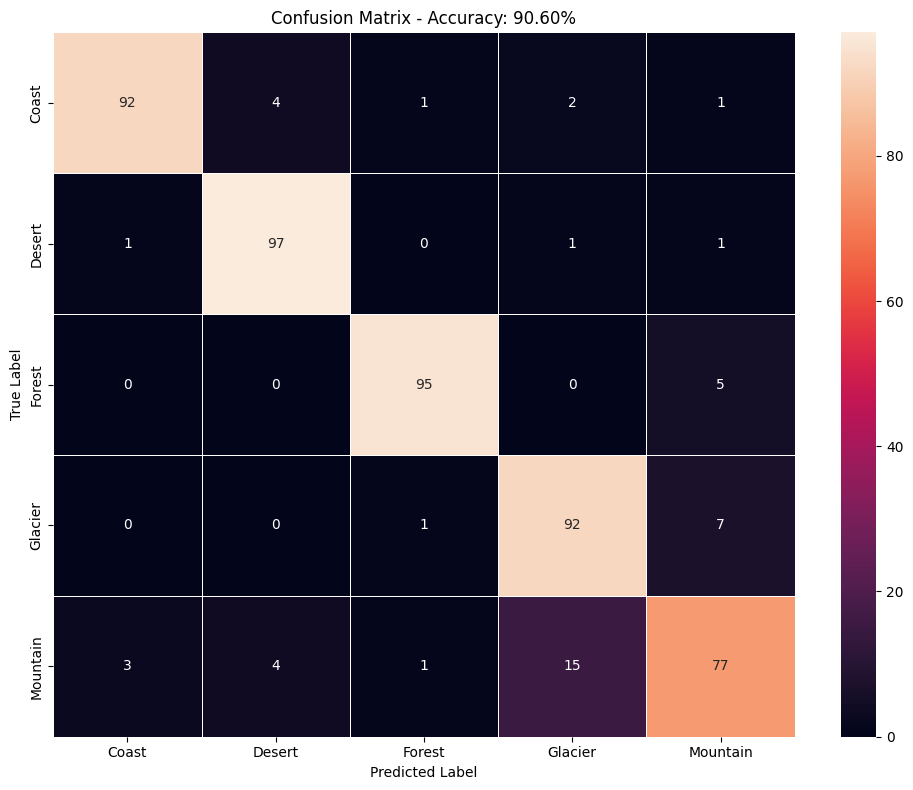

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

for x, y in test_ds:
    y_true.append(y.numpy())  # class index
    preds = model.predict(x)
    y_pred.append(np.argmax(preds, axis=-1))

# Convert to flat arrays
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
accuracy = np.sum(y_pred == y_true) / len(y_true)

print(f"Test Accuracy: {accuracy*100:.2f}%")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names if 'class_names' in locals() else None))

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="rocket", linewidths=0.5,
            xticklabels=class_names if 'class_names' in locals() else None,
            yticklabels=class_names if 'class_names' in locals() else None)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - Accuracy: {accuracy*100:.2f}%")
plt.tight_layout()
plt.show()
